In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import utils

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, f1_score

from xgboost import XGBClassifier

In [2]:
def split(X, y, test_size=0.2):
    X = X.to_numpy()
    y = y.to_numpy()
    sss = StratifiedShuffleSplit(test_size = test_size, random_state=0)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    return (X_train, y_train, X_test, y_test)

In [3]:
def PlotConfusionMatrix(classifier, X, y, normalize='true', axes=None):
    '''
    Plots the confusion matrix of X based on predictions
    from classifier.
    
    @param classifier Classifier for doing predictions.
    @param X Input data.
    @param y Output labels.
    @param normalize Specifies the mode of normalization.
        It takes values 'true', 'pred' and 'all'.
    '''
    plot = plot_confusion_matrix(classifier, X, y, normalize = normalize,
                                 display_labels=CLASS_NAMES, cmap=plt.cm.Blues, ax=axes)

In [4]:
def TrainingPipeline(model, X_train, y_train, X_val, y_val):
    
    # A dictionary to store the history of the trained model.
    history = {}
    
    # Training and Predicting.
    model.fit(X_train, y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    history["model"] = model
    history["y_train_hat"] = y_train_hat
    history["y_val_hat"] = y_val_hat
    
    # Plotting confusion matrices.
    fig, axes = plt.subplots(1, 2, figsize=(13,5))
    PlotConfusionMatrix(model, X_train, y_train, axes=axes[0])
    PlotConfusionMatrix(model, X_val, y_val, axes=axes[1])
    axes[0].set_title("Confustion matrix of Train Data")
    axes[1].set_title("Confustion matrix of Test Data")
    
    # Calculating the scores.
    train_score = utils.Score(f1_score, y_train, y_train_hat, average="weighted").round(4)
    val_score = utils.Score(f1_score, y_val, y_val_hat, average="weighted").round(4)
    history["train_score"] = train_score
    history["val_score"] = val_score
    
    print("Training Score is", train_score)
    print("Validation Score is", val_score)
    return history

In [8]:
train = pd.read_csv("data/train_age_dataset.csv")
test = pd.read_csv("data/test_age_dataset.csv")

In [6]:
# train["new"]=train['userId']+train['creations']
# train["new1"]=train['userId']+2*train['creations']
# train["new2"]=2*train['userId']+train['creations']
# train["total_slots"]=train['slot1_trails_watched_per_day']+train['slot2_trails_watched_per_day']+train['slot3_trails_watched_per_day']+train['slot4_trails_watched_per_day']

# test["new"]=test['userId']+test['creations']
# test["new1"]=test['userId']+2*test['creations']
# test["new2"]=2*test['userId']+test['creations']
# test["total_slots"]=test['slot1_trails_watched_per_day']+test['slot2_trails_watched_per_day']+test['slot3_trails_watched_per_day']+test['slot4_trails_watched_per_day']

In [9]:
CLASS_NAMES = list(train["age_group"].unique())

In [10]:
# drop = ["Unnamed: 0", "userId"]
# train = utils.DropFeatures(drop, train)
# test = utils.DropFeatures(drop, test)

In [11]:
X, y = utils.SplitLabels(train, "age_group")
X_train, y_train, X_val, y_val = split(X, y)

In [13]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

In [17]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)

In [20]:
x_new, y_new = balanced_subsample(X_train, y_train)

In [12]:
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
test = scaler.transform(test)

## Logistic Regression

/home/rishabh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Score is 0.5453
Validation Score is 0.5446


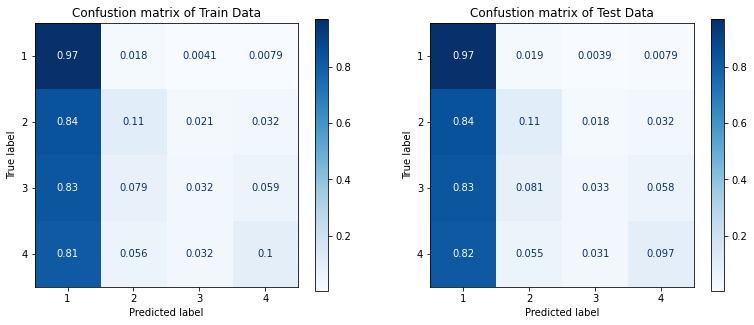

In [10]:
logistic_clf = LogisticRegression(random_state=42)
history_logistic = TrainingPipeline(logistic_clf, X_train, y_train, X_val, y_val)

In [11]:
test_pred = logistic_clf.predict(test)
test_pred = pd.Series(test_pred, name="prediction")
test_pred.to_csv("baseline.csv", index=False)

## XGBoost

Training Score is 0.7807
Validation Score is 0.7492
CPU times: user 5min 48s, sys: 88.7 ms, total: 5min 49s
Wall time: 2min 55s


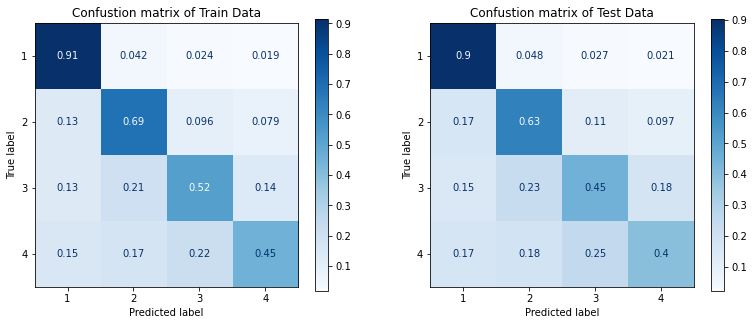

In [11]:
xgb_clf = XGBClassifier(nthread = 2)
history_xgb = TrainingPipeline(xgb_clf, X_train, y_train, X_val, y_val)

In [21]:
test_pred = xgb_clf.predict(test)
test_pred = pd.Series(test_pred, name="prediction")
test_pred.to_csv("xgb.csv", index=False)

## Random Forest

Training Score is 0.5298
Validation Score is 0.5274
timr: 12.037602663040161


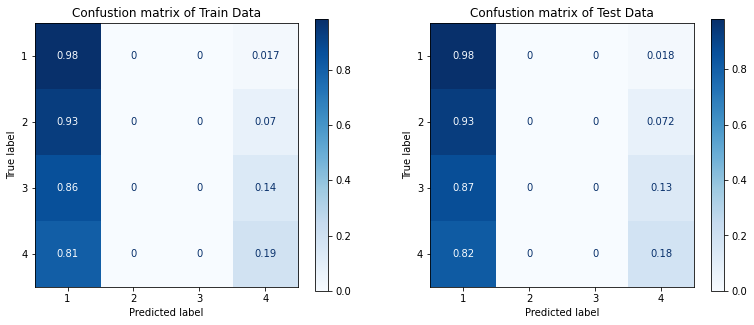

In [16]:
forest_clf = RandomForestClassifier(max_depth=2, random_state=0, n_jobs=4)
history_forest = TrainingPipeline(forest_clf, X_train, y_train, X_val, y_val)

In [17]:
test_pred = forest_clf.predict(test)
test_pred = pd.Series(test_pred, name="prediction")
test_pred.to_csv("forest.csv", index=False)

## Applying bagging methods

#### XGB

Training Score is 0.8186
Validation Score is 0.7882


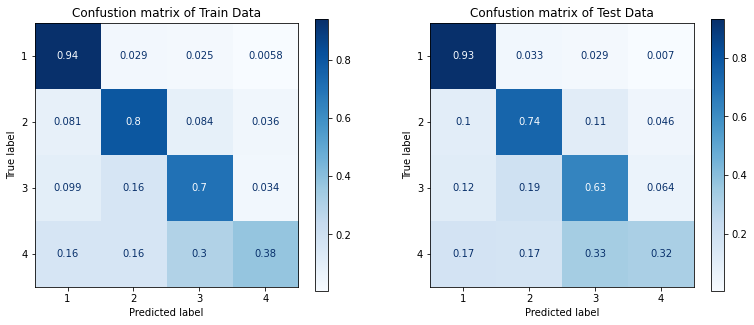

In [11]:
bagging_xgb_clf = BaggingClassifier(base_estimator = XGBClassifier(), n_estimators=10, random_state=0)
history_bagging_xgb = TrainingPipeline(bagging_xgb_clf, X_train, y_train, X_val, y_val)

In [12]:
test_pred = bagging_xgb_clf.predict(test)
test_pred = pd.Series(test_pred, name="prediction")
test_pred.to_csv("bagging_xgb.csv", index=False)

## Applying Stacking

#### bagging_xgb_clf and 

/home/rishabh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Score is 0.8081
Validation Score is 0.7897


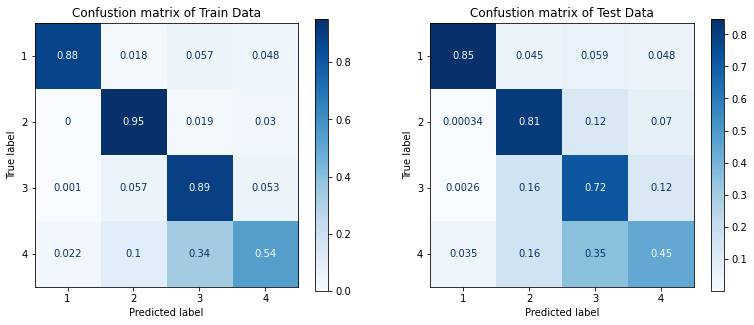

In [25]:
estimators = [("bagging_xgb_clf", BaggingClassifier(base_estimator = XGBClassifier(), n_estimators=10, random_state=0)),
              ("gradient_boosting", GradientBoostingClassifier(n_estimators=100,max_depth=12))]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
history_stacking = TrainingPipeline(stacking_clf, x_new, y_new, X_val, y_val)

In [27]:
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

allDone()

In [33]:
test_pred = stacking_clf.predict(test)
test_pred = pd.Series(test_pred, name="prediction")
test_pred.to_csv("stacking_clf.csv", index=False)

In [34]:
abc = pd.read_csv("stacking_clf.csv")

In [32]:
abc["prediction"].value_counts()

1.0    29304
3.0    10132
2.0     8987
4.0     5897
Name: prediction, dtype: int64

In [35]:
abc["prediction"].value_counts()

1.0    29304
3.0    10132
2.0     8987
4.0     5897
Name: prediction, dtype: int64

In [36]:
de = pd.read_csv("bagging_xgb.csv") 

In [45]:
x = de["prediction"] == abc["prediction"]

In [46]:
len(abc)

54320

In [48]:
x.sum()/ len(x)

0.8544918998527246